# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

BATCH_SIZE = 32

Using cpu device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [2]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [3]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

In [4]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               device: torch.device = 'cpu',
               return_all = False):
    loss = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
        loss /= len(data_loader)
    if(return_all):
        return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item()
            }
    else:
        return loss.item()

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [5]:
def train_test_model(epoch : int, 
                     model: torch.nn.Module,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader = None,
                     device: torch.device = 'cpu',
                     test: bool = True,
                     seed: int = 42):
    torch.manual_seed(seed)
    train_loss_arr = []
    test_loss_arr = []
    error_dist_train = []
    error_dist_test = []
    if(test):
        for epochs in range(epoch):
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))

            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']
            
            test_loss = test_step(model, test_loader, loss_fn, device)
            test_loss_arr.append(test_loss / len(test_loader))
            error_dist_train.append(eval_model(model,train_loader,loss_fn,device))
            error_dist_test.append(eval_model(model,train_loader,loss_fn,device))
            if (epochs) % 10 == 0 or epochs == 0:
                print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
            elif epochs + 1 == epoch:
                print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | Loss test: {test_loss_arr[-1]} | lr = {after_lr}')
        return train_loss_arr, test_loss_arr, error_dist_train, error_dist_test
    else:
        for epochs in range(epoch):
            epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
            train_loss_arr.append(epoch_loss / len(train_loader))
            error_dist_train.append(eval_model(model,train_loader,loss_fn,device))
            scheduler.step(epoch_loss)
            after_lr = optimizer.param_groups[0]['lr']
            if (epochs) % 10 == 0 or epochs == 0:
                print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]} | lr = {after_lr}')
            elif epochs + 1 == epoch:
                print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]} | lr = {after_lr}')
        return train_loss_arr,error_dist_train


Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [6]:
def plot_results(train_arr, test_arr, error_train,error_test):
    # Plot the loss curves
    if(np.max(train_arr) != np.min(train_arr)):
        train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    else:
        print("Min and max of train array are the same")
        print(train_arr)
        return
    if(np.max(test_arr) != np.min(test_arr)):
        test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    else:
        print("Min and Max of test array are the same")
        print(test_arr)
        return
    # plt.figure(figsize=(8, 5))
    # plt.plot(train_arr, label='Train Loss')
    # plt.plot(test_arr, label='Test Loss')
    # plt.xlabel("Epochs")
    # plt.ylabel("Normalized Loss")
    # plt.title("Normalized Training Loss")
    # plt.grid()
    # plt.legend()
    # plt.show()


    lin = np.linspace(0,1,len(train_arr))

    axis1 = plt.subplot(211)
    axis2 = plt.subplot(212)
    axis1.plot(lin,train_arr,color='red',label = 'Train loss')
    axis1.plot(lin,test_arr,color='blue',label="Test loss")
    axis1.set_xlabel('epochs')
    axis1.set_ylabel('Normalized loss')
    axis1.set_title('Train and test loss per epoch')
    axis1.legend()
    axis1.grid(True)
    
    axis2.plot(lin,error_test,color='red',label = 'Train error')
    axis2.plot(lin,error_test,color='blue',label="Test error")
    axis2.set_xlabel('epochs')
    axis2.set_ylabel('error')
    axis2.set_title('Train and test error per epoch')
    axis2.legend()
    axis2.grid(True)
    
    plt.tight_layout()
    plt.show()

***

## Εισαγωγή δεδομένων

Η συνάρτηση αυτή δέχεται τα paths των δεδομένων, δημιουργεί και επιστρέφει τα mini_batches που θα χρησιμοποιηθούν στο training.

ΣΟΣ Να αλλάξουμε το scaling method

In [7]:
def data_func(input_array, labels, batch_size = BATCH_SIZE, test_size = 0.2):
    # Reshape the tensor to 2D so that it can be used in the linear model
    X = input_array.reshape(len(input_array), -1)
    y = labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    
    scaler = StandardScaler()
    # Fit the scaler on the training data and transform both the training and test sets
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Transform the data to PyTorch tensors and move them to the GPU if available
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the dataset
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Define the data loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [8]:
# Define the pickle file name and relative path
pickle_name = "Sim_Data_Noisy_Interp.pkl"
folder_name = "Sim_Data_0"  # Change accordingly

relative_path = os.path.join("..", "Simulation", folder_name, pickle_name)

# Resolve the absolute path
file_path = os.path.abspath(relative_path)

try:
    # Check if the file exists before attempting to read
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    # Load the pickle file
    df = pd.read_pickle(file_path)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

df.head()


,tag_pos,Antenna,robot_pos,Phases
0,"[1.3374070790110344, 0.1, 0.1]",[0],"[0.6625929209889657, 0.6661549086159794, 0.669...","[0.0, -0.10487150506512838, -0.221901548402660..."
1,"[1.9494820917610742, 0.1, 0.1]",[0],"[0.05051790823892587, 0.054072937717603915, 0....","[0.0, -0.10101337624334959, -0.321809004322664..."
2,"[0.4116242295452528, 0.1, 0.1]",[0],"[1.5883757704547472, 1.5920683760992664, 1.595...","[0.0, -0.13453695823921752, -0.255845581716036..."
3,"[1.2026705067177903, 0.1, 0.1]",[0],"[0.7973294932822097, 0.80090229956099, 0.80447...","[0.0, -0.14502076970326194, -0.377630922159475..."
4,"[1.4467800565600593, 0.1, 0.1]",[0],"[0.5532199434399407, 0.5567733429395528, 0.560...","[0.0, -0.12889416459989012, -0.239887498367972..."


Δημιουργούμε τα training και testing sets.

In [9]:
rfid_label = np.array(df['tag_pos'].tolist())[:, :2] 
rfid_label.shape

(10000, 2)

In [10]:
# Convert columns to NumPy arrays
robot_pos_array = np.stack(df["robot_pos"].to_numpy())  # Shape: (10000, 400)
phases_array = np.stack(df["Phases"].to_numpy())  # Shape: (10000, 400)

# Concatenate along the last axis
info_tensor = np.stack((robot_pos_array, phases_array), axis=-1)  # Shape: (10000, 400, 2)
info_tensor.shape

(10000, 400, 2)

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως κινήθηκε κατά τον άξονα **Χ** και την μέτρηση της **φάσης** του.

In [11]:
train_loader, test_loader = data_func(info_tensor, rfid_label)

In [12]:
len(train_loader) # Should be (total_tags / batch_size) * train_partition 

250

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [13]:
output_len = rfid_label.shape[1]
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(800, 2)

***

## Φακελοποίηση και αποθήκευση μοντέλων

In [14]:
from pathlib import Path

# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

# Initialize a list to store the indices
existing_indices = []

# Iterate through the folders in the directory
for folder in parent_dir.iterdir():
    if folder.is_dir() and folder.name.startswith("NN_Data_"):  # Check if it's a directory and follows the pattern
        try:
            index = int(folder.name[len("NN_Data_"):])  # Extract the number part
            existing_indices.append(index)
        except ValueError:
            pass  # Ignore folders that don't have a valid integer index

# Determine the next index
new_index = (max(existing_indices) + 1) if existing_indices else 0

# Create the new folder
new_folder_path = parent_dir / f"NN_Data_{new_index}"
new_folder_path.mkdir(exist_ok=True)

print(f"Created folder: {new_folder_path}")

Created folder: c:\Users\giama\Desktop\ece_auth\semester10\NNs-on-RFID-Localization\Neural_Networks\NN_Data_5


In [15]:

def save_model_info(model:nn.Module,filename):
    p = Path(f"{filename}.pt")
    torch.save(model.state_dict(),p)

def load_model_info(model,filename):
    if not isinstance(filename,Path):
        p = Path(filename)
        if(p.exists()):
            model.load_state_dict(torch.load(p))
        else:
            print(f"{filename} doesn't exist")
    else:
        model.load_state_dict(torch.load(filename,map_location=device))
    return model

##  Cross-Validation

In [16]:
def cv_NN(model_class: torch.nn.Module, 
          model_params,
        X: np.ndarray,
        y: np.ndarray,
        splits: int, 
        loss_fn: torch.nn.Module,
        optimizer_class: torch.optim.Optimizer,
        optimizer_params,
        scheduler_class,
        scheduler_params, 
        device=device,
        random_state: int = 42):
    final_errors = []
    for i in range(splits):
        model = model_class(**model_params)
        optimizer = optimizer_class(model.parameters(),**optimizer_params)

        scheduler = None
        if scheduler_class is not None and scheduler_params is not None:
            scheduler = scheduler_class(optimizer, **scheduler_params)
        split_set = np.vsplit(X,splits)
        split_lab = np.vsplit(y,splits)

        test_data = split_set[i]
        test_labels = split_lab[i]
        split_set.pop(i)
        split_lab.pop(i)
        train_data = np.vstack(split_set)
        train_labels = np.vstack(split_lab)
        tr_data = TensorDataset(torch.from_numpy(train_data).type(torch.float32).to(device),torch.from_numpy(train_labels).type(torch.float32).to(device))
        te_data = TensorDataset(torch.from_numpy(test_data).type(torch.float32).to(device),torch.from_numpy(test_labels).type(torch.float32).to(device))
        print(len(tr_data))
        train_dataloader = DataLoader(tr_data,batch_size=BATCH_SIZE,shuffle=False)
        print(len(train_dataloader))
        test_dataloader = DataLoader(te_data,batch_size=BATCH_SIZE,shuffle=False)

        train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model, train_loader= train_dataloader, test_loader= test_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)
        final_errors.append(test_err[-1])
        plot_results(train_loss, test_loss,train_err,test_err)
    return np.array(final_errors)


Shuffle the dataset because we don't want it to be ordered

In [17]:
X = info_tensor.reshape(len(info_tensor), -1)
indices = np.arange(len(info_tensor))
np.random.shuffle(indices)
y = rfid_label
X = X[indices,:]
y = y[indices,:]

train_whole_data = TensorDataset(torch.from_numpy(X).type(torch.float32).to(device),torch.from_numpy(y).type(torch.float32).to(device))
train_whole_dataloader = DataLoader(train_whole_data,batch_size=BATCH_SIZE,shuffle=False)
print(len(train_whole_dataloader))

313


## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [18]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

8000
250
Epoch 0 | Loss train: 63.052724626541135 | Loss test: 105.34228527735151 | lr = 0.01
Epoch 10 | Loss train: 49.183906811714174 | Loss test: 4.661368706869701 | lr = 0.01
Epoch 20 | Loss train: 0.7279711874723435 | Loss test: 0.49604130784670514 | lr = 0.001
Epoch 30 | Loss train: 0.30162458384037016 | Loss test: 0.2667494747373793 | lr = 0.0001
Epoch 40 | Loss train: 0.27490678960084913 | Loss test: 0.2543825173661822 | lr = 0.0001
Epoch 50 | Loss train: 0.2709341571331024 | Loss test: 0.2854620398037017 | lr = 0.0001
Epoch 60 | Loss train: 0.24526318916678427 | Loss test: 0.24258695424549162 | lr = 1e-05
Epoch 70 | Loss train: 0.24506270688772203 | Loss test: 0.24270848054734487 | lr = 1e-05
Epoch 80 | Loss train: 0.24286001333594323 | Loss test: 0.24301425746035954 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.2426811273396015 | Loss test: 0.24288782465552528 | lr = 1.0000000000000002e-07
Epoch 100 | Loss train: 0.2427194581925869 | Loss test: 0.24286827031109068 | 

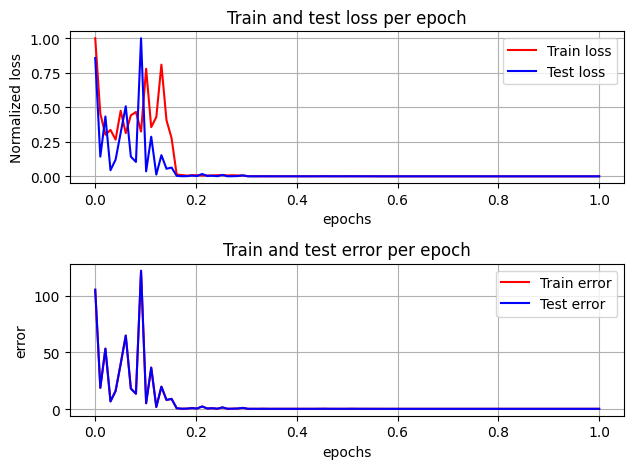

8000
250
Epoch 0 | Loss train: 46.087387372493744 | Loss test: 36.51992416381836 | lr = 0.01
Epoch 10 | Loss train: 25.830373590350153 | Loss test: 7.611983163016183 | lr = 0.01
Epoch 20 | Loss train: 15.6729803814888 | Loss test: 7.456738736894396 | lr = 0.01
Epoch 30 | Loss train: 28.122317473888398 | Loss test: 65.13062964545355 | lr = 0.01
Epoch 40 | Loss train: 0.6765242507457733 | Loss test: 1.0566345046436976 | lr = 0.001
Epoch 50 | Loss train: 0.2601674720942974 | Loss test: 0.24577911340055011 | lr = 0.0001
Epoch 60 | Loss train: 0.26304590594768523 | Loss test: 0.24316580037749003 | lr = 0.0001
Epoch 70 | Loss train: 0.24332910749316217 | Loss test: 0.2409697709575532 | lr = 1e-05
Epoch 80 | Loss train: 0.24308503314852714 | Loss test: 0.24102292505521622 | lr = 1e-05
Epoch 90 | Loss train: 0.23974494576454164 | Loss test: 0.24135771819523402 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.23967490857839585 | Loss test: 0.2414639518847541 | lr = 1.0000000000000002e-07

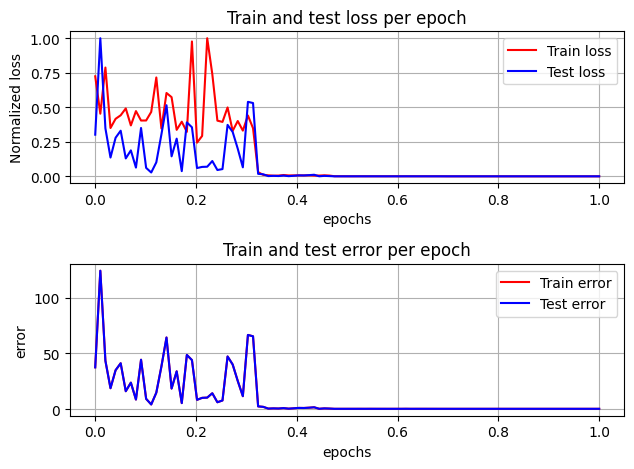

8000
250
Epoch 0 | Loss train: 39.1158986916542 | Loss test: 17.40858585115463 | lr = 0.01
Epoch 10 | Loss train: 31.353864042282105 | Loss test: 35.9789014241052 | lr = 0.01
Epoch 20 | Loss train: 31.99349923324585 | Loss test: 2.848865130591014 | lr = 0.001
Epoch 30 | Loss train: 0.670215338230133 | Loss test: 0.386665197591933 | lr = 0.001
Epoch 40 | Loss train: 0.6318531150221824 | Loss test: 0.5109666812987554 | lr = 0.001
Epoch 50 | Loss train: 0.2681461855471134 | Loss test: 0.2788623488611645 | lr = 0.0001
Epoch 60 | Loss train: 0.26335189497470857 | Loss test: 0.2559548810360924 | lr = 0.0001
Epoch 70 | Loss train: 0.24140733855962754 | Loss test: 0.25364294470775695 | lr = 1e-05
Epoch 80 | Loss train: 0.24133676314353944 | Loss test: 0.2532453250790399 | lr = 1e-05
Epoch 90 | Loss train: 0.23820596972107888 | Loss test: 0.2521314463681645 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.2379148689210415 | Loss test: 0.25275186271894545 | lr = 1.0000000000000002e-07


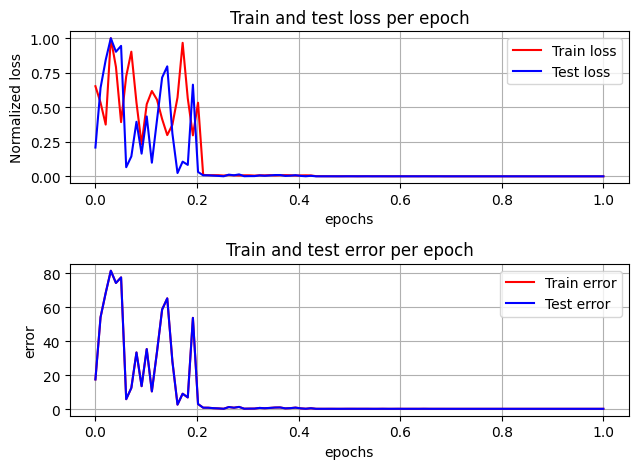

8000
250
Epoch 0 | Loss train: 45.95037724399567 | Loss test: 3.25402537792448 | lr = 0.01
Epoch 10 | Loss train: 21.552769935846328 | Loss test: 6.6725453195117765 | lr = 0.01
Epoch 20 | Loss train: 0.7706721371412277 | Loss test: 1.2809897358455355 | lr = 0.001
Epoch 30 | Loss train: 0.5534977724552155 | Loss test: 0.5596769054730734 | lr = 0.001
Epoch 40 | Loss train: 0.26771873340010643 | Loss test: 0.25097185952795875 | lr = 0.0001
Epoch 50 | Loss train: 0.26774903762340546 | Loss test: 0.24996564832944718 | lr = 0.0001
Epoch 60 | Loss train: 0.2729774529337883 | Loss test: 0.2516680719360473 | lr = 0.0001
Epoch 70 | Loss train: 0.24374903079867363 | Loss test: 0.2445810917350981 | lr = 1e-05
Epoch 80 | Loss train: 0.24367693164944648 | Loss test: 0.24439135004603674 | lr = 1e-05
Epoch 90 | Loss train: 0.24166530492901803 | Loss test: 0.2430021119496179 | lr = 1.0000000000000002e-06
Epoch 100 | Loss train: 0.24164126059412958 | Loss test: 0.2429573926187697 | lr = 1.00000000000000

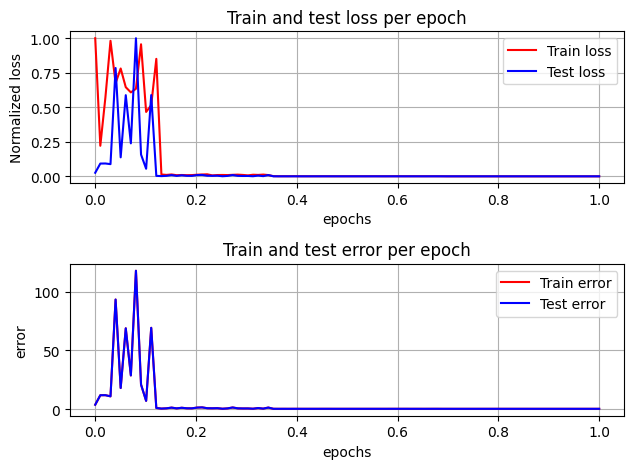

8000
250
Epoch 0 | Loss train: 45.17400922012329 | Loss test: 15.410726547241211 | lr = 0.01
Epoch 10 | Loss train: 18.542260152339935 | Loss test: 18.594661409892733 | lr = 0.01
Epoch 20 | Loss train: 0.5670569609701633 | Loss test: 0.46341533580469707 | lr = 0.001
Epoch 30 | Loss train: 0.27247920271754267 | Loss test: 0.30499822303416235 | lr = 0.0001
Epoch 40 | Loss train: 0.2665205361545086 | Loss test: 0.3029624569037604 | lr = 0.0001
Epoch 50 | Loss train: 0.26997074869275095 | Loss test: 0.29229499163135647 | lr = 0.0001
Epoch 60 | Loss train: 0.24476557821035386 | Loss test: 0.27693206048201 | lr = 1e-05
Epoch 70 | Loss train: 0.24475945296883583 | Loss test: 0.27493765524455477 | lr = 1e-05
Epoch 80 | Loss train: 0.2428487004339695 | Loss test: 0.2755601316217392 | lr = 1.0000000000000002e-06
Epoch 90 | Loss train: 0.24272171899676323 | Loss test: 0.2756012591814238 | lr = 1.0000000000000002e-07
Epoch 100 | Loss train: 0.24262445971369742 | Loss test: 0.27535357716537656 | lr

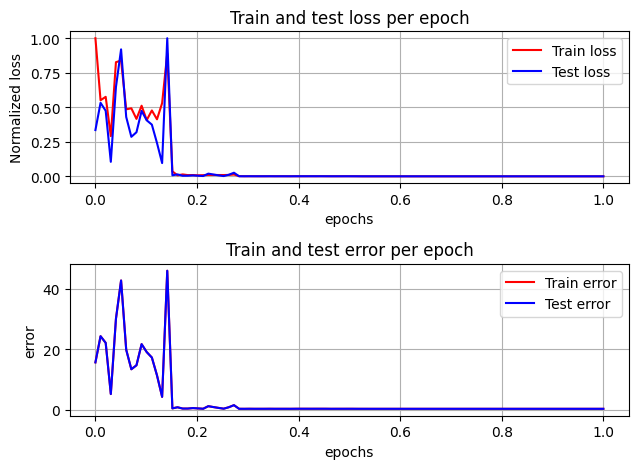

Completed CV with num splits: 5 and final error 0.2408114641904831


In [19]:
loss_fn = nn.MSELoss()

optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
model_params = {'input_size': input_len, 'output_size': output_len}
num_splits = 5
errors = cv_NN(model_class=SimpleModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")

In [20]:
print(f"Completed CV with num splits: {num_splits} and final error {errors}")

Completed CV with num splits: 5 and final error [0.24266306 0.23965533 0.23785327 0.24132185 0.24256381]


Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

8000
250
Epoch 0 | Loss train: 2580.4984197387694 | Loss test: 818.7844727531312 | lr = 0.01
Epoch 10 | Loss train: 685.7263763427734 | Loss test: 849.292472718254 | lr = 0.01
Epoch 20 | Loss train: 7.271802910804748 | Loss test: 9.102355101751902 | lr = 0.001
Epoch 30 | Loss train: 7.213456428527832 | Loss test: 8.62393231618972 | lr = 0.001
Epoch 40 | Loss train: 7.185469784736633 | Loss test: 8.512011861044263 | lr = 0.001
Epoch 50 | Loss train: 7.146463187217712 | Loss test: 8.092886296529619 | lr = 0.001
Epoch 60 | Loss train: 7.120141819000244 | Loss test: 7.96978229189676 | lr = 0.001
Epoch 70 | Loss train: 7.102753853797912 | Loss test: 7.929545584179106 | lr = 0.001
Epoch 80 | Loss train: 7.0933967142105105 | Loss test: 7.98261550873045 | lr = 0.001
Epoch 90 | Loss train: 7.087860350608826 | Loss test: 8.046907038915725 | lr = 0.001
Epoch 100 | Loss train: 7.117339648246765 | Loss test: 8.71462093080793 | lr = 0.001


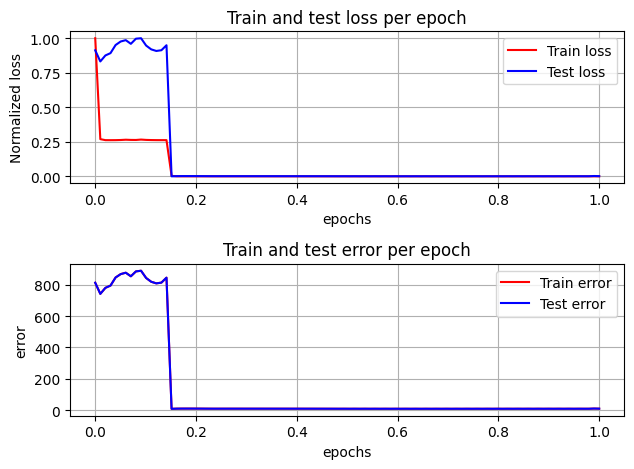

8000
250
Epoch 0 | Loss train: 2488.175653137207 | Loss test: 796.604491703094 | lr = 0.01
Epoch 10 | Loss train: 689.1752608642578 | Loss test: 836.5980486188616 | lr = 0.01
Epoch 20 | Loss train: 7.483772463798523 | Loss test: 10.853920997135223 | lr = 0.001
Epoch 30 | Loss train: 7.1690607233047485 | Loss test: 8.018300041319831 | lr = 0.001
Epoch 40 | Loss train: 7.213028781890869 | Loss test: 9.40269176543705 | lr = 0.001
Epoch 50 | Loss train: 7.191490409851074 | Loss test: 9.303891802590991 | lr = 0.001
Epoch 60 | Loss train: 0.3574594506621361 | Loss test: 0.5521241610958463 | lr = 0.0001
Epoch 70 | Loss train: 0.35369519704580304 | Loss test: 0.5498225248995281 | lr = 0.0001
Epoch 80 | Loss train: 0.35289642357826234 | Loss test: 0.5384966764185164 | lr = 0.0001
Epoch 90 | Loss train: 0.34818280780315397 | Loss test: 0.5424412309177338 | lr = 0.0001
Epoch 100 | Loss train: 0.2556541557610035 | Loss test: 0.2486616720755895 | lr = 1e-05


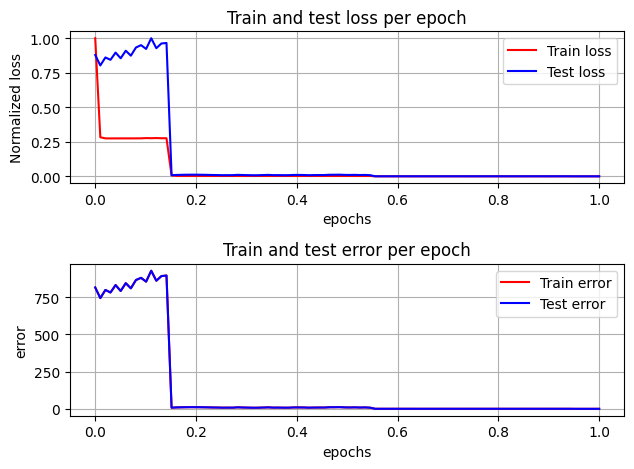

8000
250
Epoch 0 | Loss train: 2479.313219055176 | Loss test: 805.7274431501116 | lr = 0.01
Epoch 10 | Loss train: 697.4954578857422 | Loss test: 1000.0956101190476 | lr = 0.01
Epoch 20 | Loss train: 7.572880548000335 | Loss test: 10.995378373161195 | lr = 0.001
Epoch 30 | Loss train: 7.204145510196685 | Loss test: 11.50298870177496 | lr = 0.001
Epoch 40 | Loss train: 7.3294064197540285 | Loss test: 12.733285207597037 | lr = 0.001
Epoch 50 | Loss train: 7.261325085639954 | Loss test: 9.830194359733945 | lr = 0.001
Epoch 60 | Loss train: 7.102511046409607 | Loss test: 9.308802627381825 | lr = 0.001
Epoch 70 | Loss train: 0.35059752613306044 | Loss test: 0.5192737167789823 | lr = 0.0001
Epoch 80 | Loss train: 0.3431900636553764 | Loss test: 0.4291633958854372 | lr = 0.0001
Epoch 90 | Loss train: 0.3424283111691475 | Loss test: 0.4239815471191255 | lr = 0.0001
Epoch 100 | Loss train: 0.3435050712227821 | Loss test: 0.46384726251874653 | lr = 0.0001


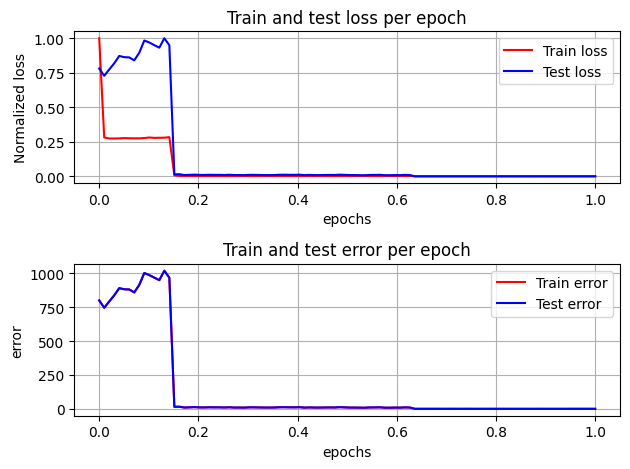

8000
250
Epoch 0 | Loss train: 2482.3810501098633 | Loss test: 792.1754504007007 | lr = 0.01
Epoch 10 | Loss train: 684.2555041503906 | Loss test: 826.2207762703063 | lr = 0.01
Epoch 20 | Loss train: 7.409578926086426 | Loss test: 10.8902492977324 | lr = 0.001
Epoch 30 | Loss train: 7.173397708892822 | Loss test: 8.319668081071642 | lr = 0.001
Epoch 40 | Loss train: 7.126148846626282 | Loss test: 8.3095169445825 | lr = 0.001
Epoch 50 | Loss train: 7.095854632377624 | Loss test: 8.463589448777457 | lr = 0.001
Epoch 60 | Loss train: 7.129922575950623 | Loss test: 8.12461317153204 | lr = 0.001
Epoch 70 | Loss train: 0.35657153418660165 | Loss test: 0.4961826791838994 | lr = 0.0001
Epoch 80 | Loss train: 0.35543937569856643 | Loss test: 0.5031815426690238 | lr = 0.0001
Epoch 90 | Loss train: 0.35510658904910086 | Loss test: 0.5143181095047603 | lr = 0.0001
Epoch 100 | Loss train: 0.3540468053817749 | Loss test: 0.529383406279579 | lr = 0.0001


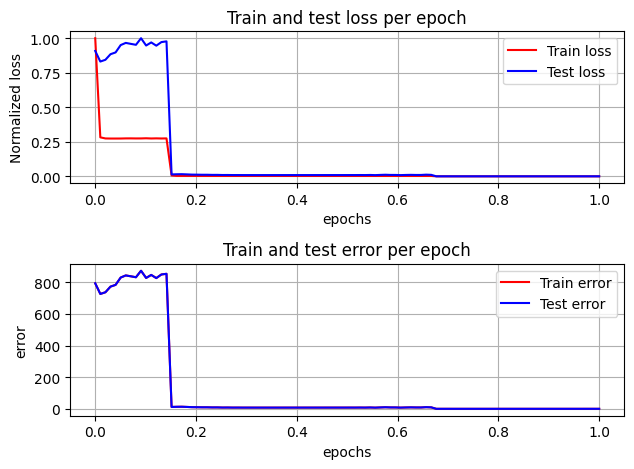

8000
250
Epoch 0 | Loss train: 2484.3896614379883 | Loss test: 684.196282765222 | lr = 0.01
Epoch 10 | Loss train: 682.1675216064453 | Loss test: 692.8520091223338 | lr = 0.01
Epoch 20 | Loss train: 681.6664154052735 | Loss test: 695.6401497977121 | lr = 0.01
Epoch 30 | Loss train: 681.2868985595703 | Loss test: 698.6564093695747 | lr = 0.01
Epoch 40 | Loss train: 680.9772338867188 | Loss test: 701.6800953698537 | lr = 0.01
Epoch 50 | Loss train: 680.7134395751954 | Loss test: 704.6229359460256 | lr = 0.01
Epoch 60 | Loss train: 680.4805520019531 | Loss test: 707.3993806384858 | lr = 0.01
Epoch 70 | Loss train: 680.2690971679688 | Loss test: 709.9337347121466 | lr = 0.01
Epoch 80 | Loss train: 680.0733365478516 | Loss test: 712.2119566902281 | lr = 0.01
Epoch 90 | Loss train: 679.8891315917969 | Loss test: 714.2214442661831 | lr = 0.01
Epoch 100 | Loss train: 679.731306274414 | Loss test: 715.8091852097284 | lr = 0.01


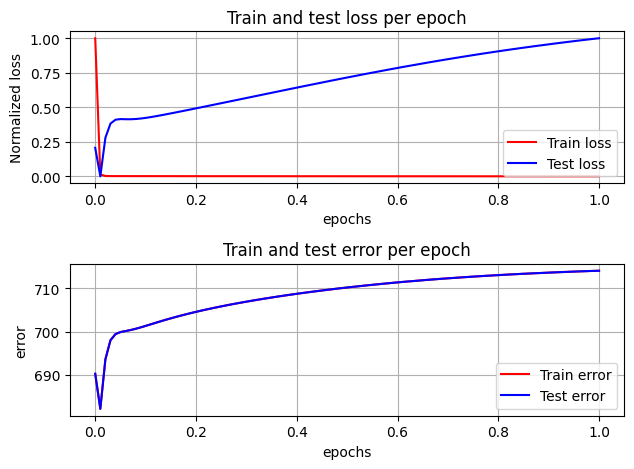

Completed CV with num splits: 5 and final error 144.82306461930276


In [21]:
loss_fn = nn.MSELoss()

optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
num_splits = 5
model_params = {'input_size': input_len, 'output_size': output_len}
errors = cv_NN(model_class=SimpleModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.RMSprop,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

8000
250
Epoch 0 | Loss train: 12.595726516723634 | Loss test: 15.019261799161397 | lr = 0.01
Epoch 10 | Loss train: 11.891300726413727 | Loss test: 16.187201136634464 | lr = 0.01
Epoch 20 | Loss train: 11.880519142627715 | Loss test: 13.80073266559177 | lr = 0.01
Epoch 30 | Loss train: 11.835162862300873 | Loss test: 15.90072939130995 | lr = 0.01
Epoch 40 | Loss train: 11.861844243526459 | Loss test: 13.220376052553691 | lr = 0.01
Epoch 50 | Loss train: 11.798915012836456 | Loss test: 15.72581933036683 | lr = 0.01
Epoch 60 | Loss train: 11.852146783828735 | Loss test: 12.981206984747024 | lr = 0.01
Epoch 70 | Loss train: 0.3676456516981125 | Loss test: 0.29541186870090547 | lr = 0.001
Epoch 80 | Loss train: 0.36337097170948984 | Loss test: 0.30511617258427637 | lr = 0.001
Epoch 90 | Loss train: 0.45068726485967636 | Loss test: 0.4626943752879188 | lr = 0.001
Epoch 100 | Loss train: 0.2564268393814564 | Loss test: 0.2763323171271218 | lr = 0.0001


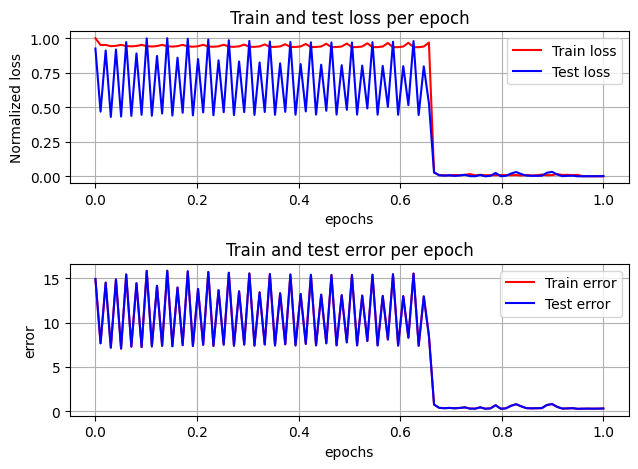

8000
250
Epoch 0 | Loss train: 12.685969542980194 | Loss test: 2.584395715168544 | lr = 0.01
Epoch 10 | Loss train: 11.914110225200654 | Loss test: 3.0534137563099937 | lr = 0.01
Epoch 20 | Loss train: 11.97737240409851 | Loss test: 2.5951682745464266 | lr = 0.01
Epoch 30 | Loss train: 11.893608913898468 | Loss test: 3.424200324785142 | lr = 0.01
Epoch 40 | Loss train: 11.985117603302003 | Loss test: 2.5572268414118935 | lr = 0.01
Epoch 50 | Loss train: 11.881922314167022 | Loss test: 3.198840434589083 | lr = 0.01
Epoch 60 | Loss train: 11.995946277618408 | Loss test: 2.4741593012734064 | lr = 0.01
Epoch 70 | Loss train: 11.872470442771911 | Loss test: 2.9265883290578447 | lr = 0.01
Epoch 80 | Loss train: 12.002901423931123 | Loss test: 2.373560833552527 | lr = 0.01
Epoch 90 | Loss train: 11.864420125961304 | Loss test: 2.738857172784351 | lr = 0.01
Epoch 100 | Loss train: 11.955276181697846 | Loss test: 18.07456650809636 | lr = 0.01


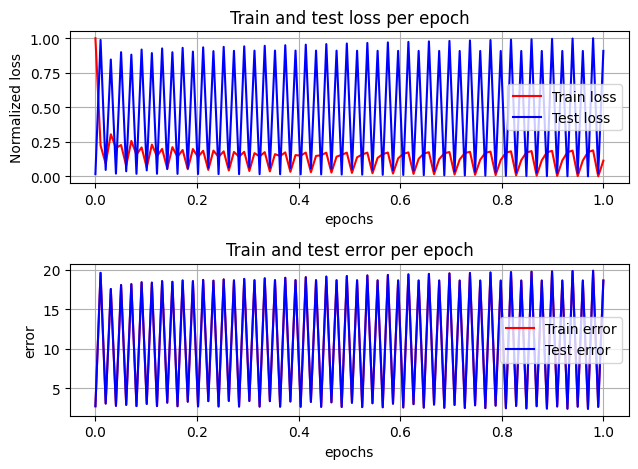

8000
250
Epoch 0 | Loss train: 12.596416879892349 | Loss test: 2.8158910331271945 | lr = 0.01
Epoch 10 | Loss train: 11.985686194896697 | Loss test: 3.344124343660143 | lr = 0.01
Epoch 20 | Loss train: 11.948904644966126 | Loss test: 2.3626775694271873 | lr = 0.01
Epoch 30 | Loss train: 11.947041053771972 | Loss test: 3.351883992316231 | lr = 0.01
Epoch 40 | Loss train: 11.945830070018769 | Loss test: 2.2724833147866383 | lr = 0.01
Epoch 50 | Loss train: 11.924135876178742 | Loss test: 2.9842189153035483 | lr = 0.01
Epoch 60 | Loss train: 11.94762415766716 | Loss test: 2.2425708288238164 | lr = 0.01
Epoch 70 | Loss train: 11.911359046459198 | Loss test: 2.670061874011206 | lr = 0.01
Epoch 80 | Loss train: 0.360162142843008 | Loss test: 0.2979232127231265 | lr = 0.001
Epoch 90 | Loss train: 0.3928011165559292 | Loss test: 0.2864216795516393 | lr = 0.001
Epoch 100 | Loss train: 0.2574131864309311 | Loss test: 0.2765219716562165 | lr = 0.0001


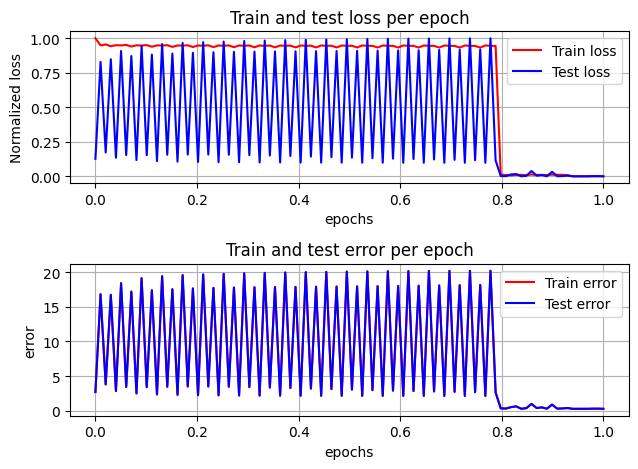

8000
250
Epoch 0 | Loss train: 12.667295695066452 | Loss test: 3.0500605976770796 | lr = 0.01
Epoch 10 | Loss train: 11.9518786277771 | Loss test: 3.5740213772607228 | lr = 0.01
Epoch 20 | Loss train: 12.032559873819352 | Loss test: 3.0926624120227872 | lr = 0.01
Epoch 30 | Loss train: 11.90673460006714 | Loss test: 3.5013145227280873 | lr = 0.01
Epoch 40 | Loss train: 12.011107545614243 | Loss test: 2.867204017109341 | lr = 0.01
Epoch 50 | Loss train: 11.890624049663543 | Loss test: 3.5421903776744057 | lr = 0.01
Epoch 60 | Loss train: 12.00800357556343 | Loss test: 2.715991801685757 | lr = 0.01
Epoch 70 | Loss train: 11.885898229598999 | Loss test: 3.5949210193422108 | lr = 0.01
Epoch 80 | Loss train: 12.010797591209412 | Loss test: 2.6271651945416887 | lr = 0.01
Epoch 90 | Loss train: 11.883764700412751 | Loss test: 3.62220381365882 | lr = 0.01
Epoch 100 | Loss train: 11.81434325313568 | Loss test: 16.914592667231485 | lr = 0.01


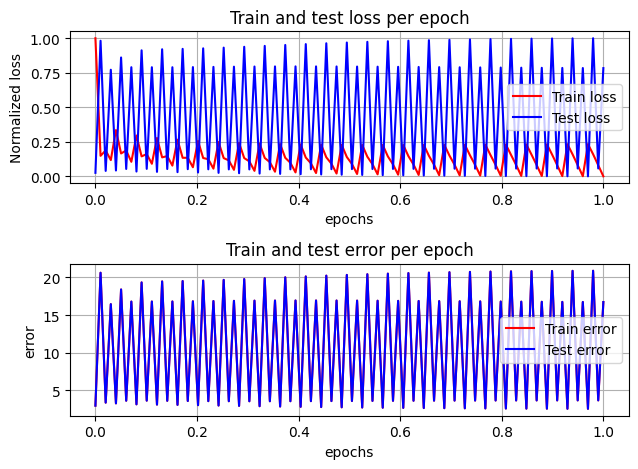

8000
250
Epoch 0 | Loss train: 12.649290977716445 | Loss test: 3.7703584640745134 | lr = 0.01
Epoch 10 | Loss train: 12.05437960243225 | Loss test: 2.5992513081384083 | lr = 0.01
Epoch 20 | Loss train: 11.94644053554535 | Loss test: 2.2741848722336786 | lr = 0.01
Epoch 30 | Loss train: 12.03364742565155 | Loss test: 2.881675536670382 | lr = 0.01
Epoch 40 | Loss train: 11.924827672481538 | Loss test: 2.2436428656653753 | lr = 0.01
Epoch 50 | Loss train: 12.030316932678222 | Loss test: 3.111801056634812 | lr = 0.01
Epoch 60 | Loss train: 11.915760518550872 | Loss test: 2.1993394181841897 | lr = 0.01
Epoch 70 | Loss train: 12.02989502811432 | Loss test: 3.2556445485069636 | lr = 0.01
Epoch 80 | Loss train: 11.911773823738098 | Loss test: 2.166026544949365 | lr = 0.01
Epoch 90 | Loss train: 12.029608820915222 | Loss test: 3.3364190222725036 | lr = 0.01
Epoch 100 | Loss train: 11.874767522096635 | Loss test: 19.732163035680376 | lr = 0.01


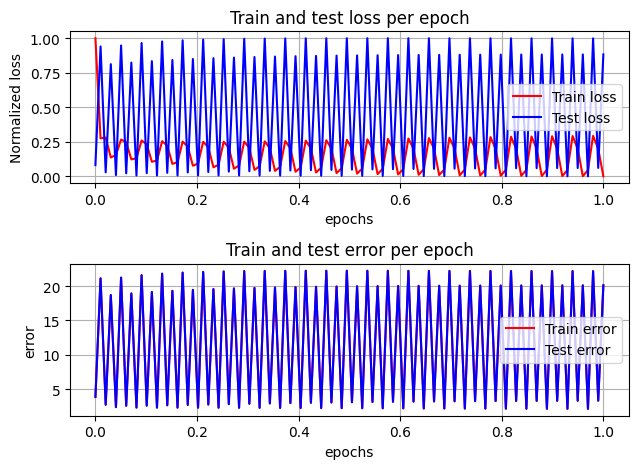

Completed CV with num splits: 5 and final error 11.200886148214341


In [22]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2,'momentum':0.9}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
num_splits = 5
model_params = {'input_size': input_len, 'output_size': output_len}
errors = cv_NN(model_class=SimpleModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.SGD,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [24]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

8000
250
Epoch 0 | Loss train: 17.797596838384866 | Loss test: 0.19474136734765674 | lr = 0.01
Epoch 10 | Loss train: 0.06597730933874846 | Loss test: 0.040992236681400784 | lr = 0.01
Epoch 20 | Loss train: 0.03911106647923589 | Loss test: 0.025116491796714917 | lr = 0.01
Epoch 30 | Loss train: 0.03486493919789791 | Loss test: 0.025989380354682606 | lr = 0.01
Epoch 40 | Loss train: 0.034331831842660906 | Loss test: 0.03103650967398333 | lr = 0.01
Epoch 50 | Loss train: 0.012764328543096781 | Loss test: 0.011776942294090986 | lr = 0.001
Epoch 60 | Loss train: 0.012087439496070147 | Loss test: 0.010993682631542758 | lr = 0.001
Epoch 70 | Loss train: 0.011951534429565073 | Loss test: 0.011348738076372279 | lr = 0.001
Epoch 80 | Loss train: 0.011886621130630375 | Loss test: 0.011384827321365712 | lr = 0.001
Epoch 90 | Loss train: 0.011868719337508082 | Loss test: 0.011227220282076842 | lr = 0.001
Epoch 100 | Loss train: 0.011746459053829312 | Loss test: 0.011306233238428831 | lr = 0.001


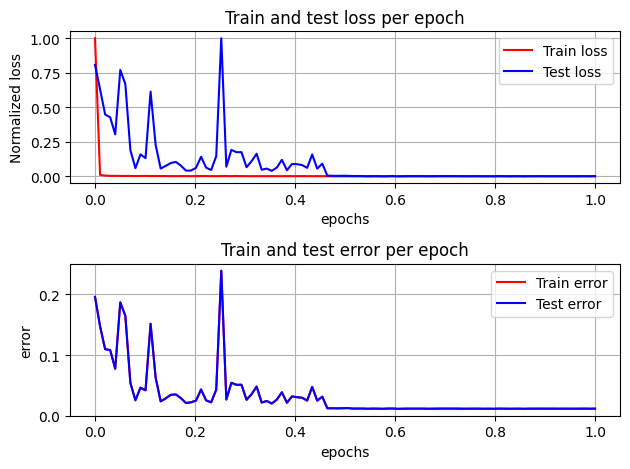

8000
250
Epoch 0 | Loss train: 17.637962462097406 | Loss test: 2.3012864154482644 | lr = 0.01
Epoch 10 | Loss train: 0.040112847365438936 | Loss test: 0.028735111038836223 | lr = 0.01
Epoch 20 | Loss train: 0.03402756597846746 | Loss test: 0.025921692997808495 | lr = 0.01
Epoch 30 | Loss train: 0.041432474344968794 | Loss test: 0.0239077630556292 | lr = 0.001
Epoch 40 | Loss train: 0.014015326669439674 | Loss test: 0.014466659912455177 | lr = 0.001
Epoch 50 | Loss train: 0.012433721957728266 | Loss test: 0.012244045409181762 | lr = 0.001
Epoch 60 | Loss train: 0.011575823053717613 | Loss test: 0.012954903581726646 | lr = 0.001
Epoch 70 | Loss train: 0.011104295279830693 | Loss test: 0.011223412761908202 | lr = 0.001
Epoch 80 | Loss train: 0.009927508367225528 | Loss test: 0.010441731883301622 | lr = 0.001
Epoch 90 | Loss train: 0.009538467418402433 | Loss test: 0.009438088496348687 | lr = 0.001
Epoch 100 | Loss train: 0.009446386639028788 | Loss test: 0.011396011522424126 | lr = 0.001


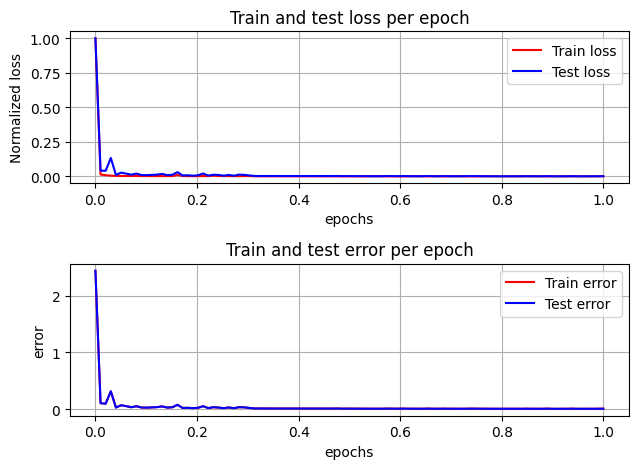

8000
250
Epoch 0 | Loss train: 17.622353608816862 | Loss test: 0.11922662297175043 | lr = 0.01
Epoch 10 | Loss train: 0.05279268183931708 | Loss test: 0.05355181113358528 | lr = 0.01
Epoch 20 | Loss train: 0.03638161044567823 | Loss test: 0.024838832517464954 | lr = 0.01
Epoch 30 | Loss train: 0.028899206794798373 | Loss test: 0.05260805427909843 | lr = 0.01
Epoch 40 | Loss train: 0.028775488529354333 | Loss test: 0.03243130812096217 | lr = 0.01
Epoch 50 | Loss train: 0.03550960955768823 | Loss test: 0.046717283715094836 | lr = 0.01
Epoch 60 | Loss train: 0.013277667541056871 | Loss test: 0.012289409983962302 | lr = 0.001
Epoch 70 | Loss train: 0.012463077198714019 | Loss test: 0.011493601001030395 | lr = 0.001
Epoch 80 | Loss train: 0.012249479310587048 | Loss test: 0.011322475282386654 | lr = 0.001
Epoch 90 | Loss train: 0.012022152680903673 | Loss test: 0.011520456655749254 | lr = 0.001
Epoch 100 | Loss train: 0.011934232169762254 | Loss test: 0.012205757939862826 | lr = 0.001


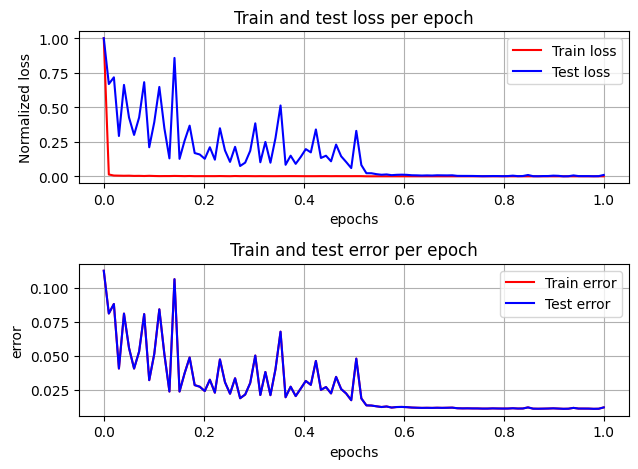

8000
250
Epoch 0 | Loss train: 17.63391505637765 | Loss test: 0.1399084608706217 | lr = 0.01
Epoch 10 | Loss train: 0.04735498662665486 | Loss test: 0.07017011159942263 | lr = 0.01
Epoch 20 | Loss train: 0.03144894419983029 | Loss test: 0.026060226299459973 | lr = 0.01
Epoch 30 | Loss train: 0.049967666760087015 | Loss test: 0.03448192588984966 | lr = 0.01
Epoch 40 | Loss train: 0.016500334978103638 | Loss test: 0.0174501169443367 | lr = 0.001
Epoch 50 | Loss train: 0.01630324764177203 | Loss test: 0.016108873329820143 | lr = 0.001
Epoch 60 | Loss train: 0.0159087145999074 | Loss test: 0.01584925917938115 | lr = 0.001
Epoch 70 | Loss train: 0.01573831144347787 | Loss test: 0.01522546847690902 | lr = 0.001
Epoch 80 | Loss train: 0.015317171920090914 | Loss test: 0.015157173069873972 | lr = 0.001
Epoch 90 | Loss train: 0.015265817664563655 | Loss test: 0.015428653992121183 | lr = 0.001
Epoch 100 | Loss train: 0.015086098738014699 | Loss test: 0.014562825258407328 | lr = 0.001


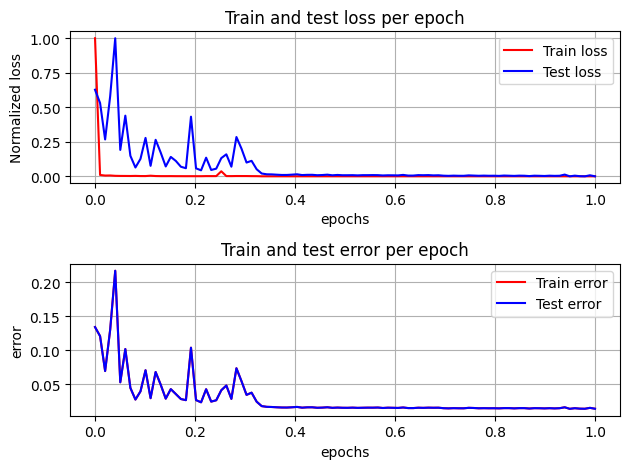

8000
250
Epoch 0 | Loss train: 17.642419614642858 | Loss test: 0.12442938871090374 | lr = 0.01
Epoch 10 | Loss train: 0.046865400500595567 | Loss test: 0.0422852338247356 | lr = 0.01
Epoch 20 | Loss train: 0.04518054390326142 | Loss test: 0.04099570327098408 | lr = 0.01
Epoch 30 | Loss train: 0.046432276163250207 | Loss test: 0.03657237880878032 | lr = 0.01
Epoch 40 | Loss train: 0.0345661240555346 | Loss test: 0.029343857060349178 | lr = 0.01
Epoch 50 | Loss train: 0.017852014776319265 | Loss test: 0.01778987129884107 | lr = 0.001
Epoch 60 | Loss train: 0.017291666358709334 | Loss test: 0.017878015082152116 | lr = 0.001
Epoch 70 | Loss train: 0.017217934932559728 | Loss test: 0.017063245768584902 | lr = 0.001
Epoch 80 | Loss train: 0.017037200182676314 | Loss test: 0.017293955790736372 | lr = 0.001
Epoch 90 | Loss train: 0.01704243322648108 | Loss test: 0.01696045399599132 | lr = 0.001
Epoch 100 | Loss train: 0.017019717063754797 | Loss test: 0.01701073216954394 | lr = 0.001


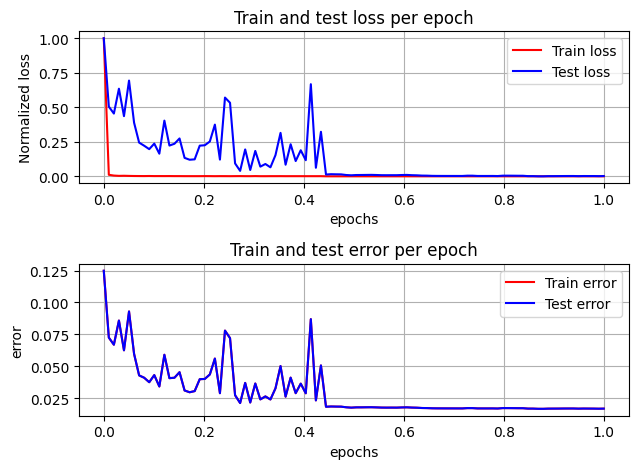

Completed CV with num splits: 5 and final error 0.013042864575982093
Epoch 0 | Loss train: 14.161962221546199 | lr = 0.01
Epoch 10 | Loss train: 0.05866704402140345 | lr = 0.01
Epoch 20 | Loss train: 0.03819691251439694 | lr = 0.01
Epoch 30 | Loss train: 0.03325119015638726 | lr = 0.01
Epoch 40 | Loss train: 0.030484658237487174 | lr = 0.01
Epoch 50 | Loss train: 0.02983399330915068 | lr = 0.01
Epoch 60 | Loss train: 0.01551075840886599 | lr = 0.001
Epoch 70 | Loss train: 0.013531313874363042 | lr = 0.001
Epoch 80 | Loss train: 0.013332175668150472 | lr = 0.001
Epoch 90 | Loss train: 0.013249350582270291 | lr = 0.001
Epoch 100 | Loss train: 0.013177119723607461 | lr = 0.001


In [25]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
num_splits = 5
model_params = {'input_size': input_len, 'output_size': output_len}
errors = cv_NN(model_class=ReLUModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")
relu_model_loss = np.mean(errors)
# Instantiate the model
model_3 = ReLUModel(input_size=input_len, output_size=output_len)



loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), **optimizer_params)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)

train_loss, train_err = train_test_model(epoch = 100,model = model_3, train_loader= train_whole_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device,test=False)

save_model_info(model_3,os.path.join(new_folder_path,"relu_model"))

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική.

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

8000
250
Epoch 0 | Loss train: 106.26139736413955 | Loss test: 0.32794277369976044 | lr = 0.01
Epoch 10 | Loss train: 0.06476154851913452 | Loss test: 0.03667145955657202 | lr = 0.01
Epoch 20 | Loss train: 0.05954599592089653 | Loss test: 0.08456076267692778 | lr = 0.01
Epoch 30 | Loss train: 0.035310814004391435 | Loss test: 0.027378986456564496 | lr = 0.01
Epoch 40 | Loss train: 0.014666038237512112 | Loss test: 0.01308590488597041 | lr = 0.001
Epoch 50 | Loss train: 0.013798596894368529 | Loss test: 0.012553598569144332 | lr = 0.001
Epoch 60 | Loss train: 0.013259699197486043 | Loss test: 0.01243192691444641 | lr = 0.001
Epoch 70 | Loss train: 0.013121692672371864 | Loss test: 0.012503545738697525 | lr = 0.001
Epoch 80 | Loss train: 0.012370820231735706 | Loss test: 0.011625257616360036 | lr = 0.001
Epoch 90 | Loss train: 0.011661430874839425 | Loss test: 0.01155154960643914 | lr = 0.001
Epoch 100 | Loss train: 0.011368134858086704 | Loss test: 0.010637029369790402 | lr = 0.001


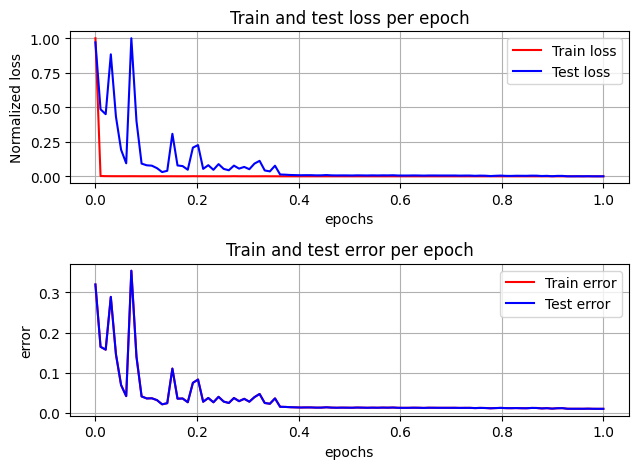

8000
250
Epoch 0 | Loss train: 123.73668298354745 | Loss test: 0.32786324170846787 | lr = 0.01
Epoch 10 | Loss train: 0.0846814269348979 | Loss test: 0.06603018336352848 | lr = 0.01
Epoch 20 | Loss train: 0.0657771944925189 | Loss test: 0.039058333647156517 | lr = 0.01
Epoch 30 | Loss train: 0.044094329677522186 | Loss test: 0.029558986691491946 | lr = 0.01
Epoch 40 | Loss train: 0.03896457237005234 | Loss test: 0.03298178258987646 | lr = 0.01
Epoch 50 | Loss train: 0.032842914380133155 | Loss test: 0.0816427773781239 | lr = 0.001
Epoch 60 | Loss train: 0.012330681355670094 | Loss test: 0.011220126516289182 | lr = 0.001
Epoch 70 | Loss train: 0.01251848071999848 | Loss test: 0.011209034486599857 | lr = 0.001
Epoch 80 | Loss train: 0.012150616638362408 | Loss test: 0.011325746708150421 | lr = 0.001
Epoch 90 | Loss train: 0.011917262969538569 | Loss test: 0.011168297180639846 | lr = 0.001
Epoch 100 | Loss train: 0.011877571227028967 | Loss test: 0.011263141585957436 | lr = 0.001


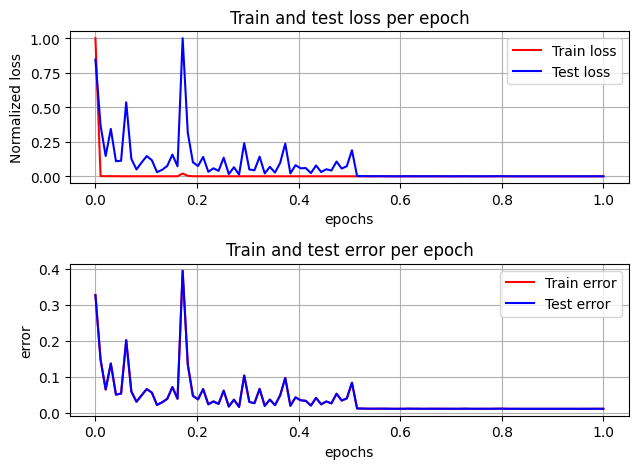

8000
250
Epoch 0 | Loss train: 123.71016850355268 | Loss test: 0.15311275996149531 | lr = 0.01
Epoch 10 | Loss train: 0.04624835525080562 | Loss test: 0.06716302805949771 | lr = 0.01
Epoch 20 | Loss train: 0.033195543099194764 | Loss test: 0.019700319757537235 | lr = 0.01
Epoch 30 | Loss train: 0.04190104808285832 | Loss test: 0.0616164468228817 | lr = 0.001
Epoch 40 | Loss train: 0.01225400758907199 | Loss test: 0.012799540246349005 | lr = 0.001
Epoch 50 | Loss train: 0.010812109877355397 | Loss test: 0.011233790127176142 | lr = 0.001
Epoch 60 | Loss train: 0.010041744942776858 | Loss test: 0.009381334341707685 | lr = 0.001
Epoch 70 | Loss train: 0.00901113322097808 | Loss test: 0.008494102662163121 | lr = 0.001
Epoch 80 | Loss train: 0.008891965562477708 | Loss test: 0.00819845222646282 | lr = 0.001
Epoch 90 | Loss train: 0.007653315449133515 | Loss test: 0.007061289024672338 | lr = 0.001
Epoch 100 | Loss train: 0.007117468562908471 | Loss test: 0.006809466806728216 | lr = 0.001


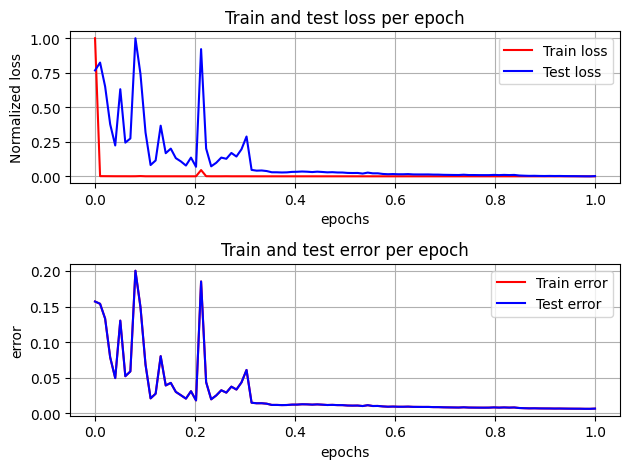

8000
250
Epoch 0 | Loss train: 123.72343078500032 | Loss test: 0.20510931360343146 | lr = 0.01
Epoch 10 | Loss train: 0.054770878717303274 | Loss test: 0.03883019406052809 | lr = 0.01
Epoch 20 | Loss train: 0.056234495982527735 | Loss test: 0.05334007323143028 | lr = 0.01
Epoch 30 | Loss train: 0.052037652797997 | Loss test: 0.029785385946669275 | lr = 0.01
Epoch 40 | Loss train: 0.063367016967386 | Loss test: 0.03721782248762865 | lr = 0.01
Epoch 50 | Loss train: 0.03841488575562835 | Loss test: 0.058460666605877495 | lr = 0.001
Epoch 60 | Loss train: 0.017590137841179968 | Loss test: 0.01770630335464837 | lr = 0.001
Epoch 70 | Loss train: 0.01608625451289117 | Loss test: 0.01599538548006898 | lr = 0.001
Epoch 80 | Loss train: 0.01563088054396212 | Loss test: 0.015277814371363512 | lr = 0.001
Epoch 90 | Loss train: 0.015009092453867197 | Loss test: 0.014775495251847638 | lr = 0.001
Epoch 100 | Loss train: 0.014744821287691593 | Loss test: 0.01476227700532902 | lr = 0.001


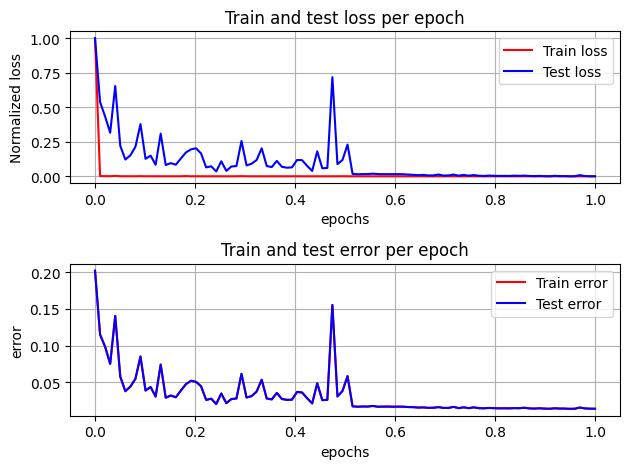

8000
250
Epoch 0 | Loss train: 123.72320470145345 | Loss test: 0.21816600906470465 | lr = 0.01
Epoch 10 | Loss train: 0.07688925548642873 | Loss test: 0.022033589212076057 | lr = 0.01
Epoch 20 | Loss train: 0.03187551217526197 | Loss test: 0.036922174461540724 | lr = 0.01
Epoch 30 | Loss train: 0.041028957404196265 | Loss test: 0.0695670654494611 | lr = 0.01
Epoch 40 | Loss train: 0.04428967274725437 | Loss test: 0.0664099764729303 | lr = 0.001
Epoch 50 | Loss train: 0.011192231215536594 | Loss test: 0.011261008192031156 | lr = 0.001
Epoch 60 | Loss train: 0.010923229465261102 | Loss test: 0.01055231604665991 | lr = 0.001
Epoch 70 | Loss train: 0.010715239005163312 | Loss test: 0.010629196156052843 | lr = 0.001
Epoch 80 | Loss train: 0.010646672008559108 | Loss test: 0.010774587037130481 | lr = 0.001
Epoch 90 | Loss train: 0.010086165117099881 | Loss test: 0.01005785639530846 | lr = 0.001
Epoch 100 | Loss train: 0.009965745205059648 | Loss test: 0.010156198907347898 | lr = 0.001


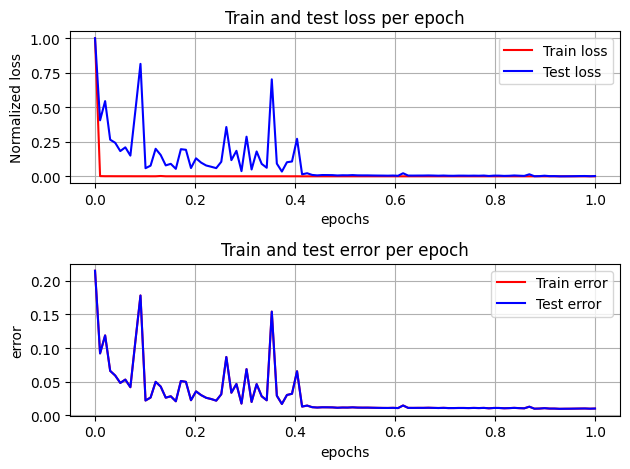

Completed CV with num splits: 5 and final error 0.010447826329618692
Epoch 0 | Loss train: 98.87834141665279 | lr = 0.01
Epoch 10 | Loss train: 0.03690194553091598 | lr = 0.01
Epoch 20 | Loss train: 0.03441427242808258 | lr = 0.01
Epoch 30 | Loss train: 0.03083131593851426 | lr = 0.01
Epoch 40 | Loss train: 0.025370997912324847 | lr = 0.01
Epoch 50 | Loss train: 0.033978014982070405 | lr = 0.01
Epoch 60 | Loss train: 0.028249908452883315 | lr = 0.01
Epoch 70 | Loss train: 0.03206544455450278 | lr = 0.01
Epoch 80 | Loss train: 0.011344368152986891 | lr = 0.001
Epoch 90 | Loss train: 0.010511008006469987 | lr = 0.001
Epoch 100 | Loss train: 0.0105042348425395 | lr = 0.001


In [28]:
loss_fn = nn.MSELoss()
optimizer_params = {'lr':1e-2}
scheduler_params = {'mode':'min','factor':0.1,"patience":10}
model_params = {'input_size':input_len, 'output_size':output_len, 'hidden_units':256}
num_splits = 5
errors = cv_NN(model_class=ReLUModel,model_params=model_params,X=X,y=y,splits=num_splits,loss_fn=loss_fn,optimizer_class=torch.optim.Adam,optimizer_params=optimizer_params,scheduler_class=lr_scheduler.ReduceLROnPlateau,scheduler_params=scheduler_params,device=device)
print(f"Completed CV with num splits: {num_splits} and final error {np.mean(errors)}")
relu_model_256_loss = np.mean(errors)
# Instantiate the model
model_4 = ReLUModel(**model_params)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), **optimizer_params)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)

train_loss, train_err = train_test_model(epoch = 100,model = model_4, train_loader= train_whole_dataloader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device,test=False)

save_model_info(model_4,os.path.join(new_folder_path,"relu_model_256"))

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64.

Epoch 0 | Loss train: 0.6839613058716059 | Loss test: 0.08295446108021433 | lr = 0.01
Epoch 10 | Loss train: 0.018889832451939582 | Loss test: 0.015706334085691543 | lr = 0.01
Epoch 20 | Loss train: 0.014083020327612758 | Loss test: 0.020804466117942143 | lr = 0.01
Epoch 30 | Loss train: 0.007594349544495344 | Loss test: 0.0053658033240704785 | lr = 0.001
Epoch 40 | Loss train: 0.004969080050475895 | Loss test: 0.0050750047537601655 | lr = 0.001
Epoch 50 | Loss train: 0.0048976604267954825 | Loss test: 0.004690497149048107 | lr = 0.001
Epoch 60 | Loss train: 0.004750702619086951 | Loss test: 0.004600639355235866 | lr = 0.001
Epoch 70 | Loss train: 0.004041012974921614 | Loss test: 0.00397256693787991 | lr = 0.0001
Epoch 80 | Loss train: 0.003943806334398687 | Loss test: 0.003911057099079092 | lr = 0.0001
Epoch 90 | Loss train: 0.0038779590362682938 | Loss test: 0.003928466962413892 | lr = 0.0001
Epoch 100 | Loss train: 0.0038447955367155373 | Loss test: 0.003899878327039972 | lr = 0.00

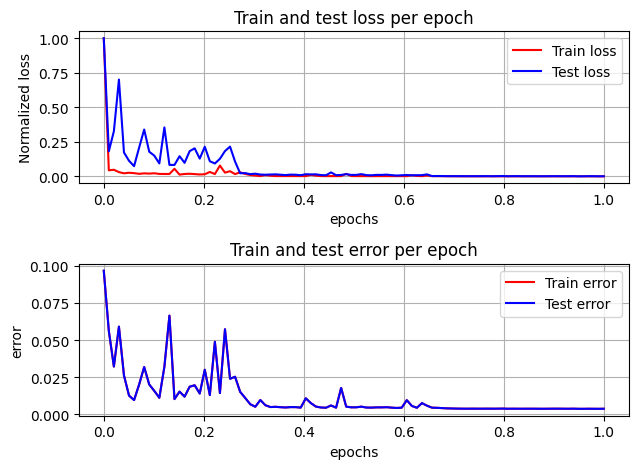

In [25]:
# Instantiate the model
model_5 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 64)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_5, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

relu_model_64 = eval_model(model_5, test_loader, loss_fn, device,True)
save_model_info(model_5,os.path.join(new_folder_path,relu_model_64["model_name"]))

In [26]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel', 'model_loss': 0.003962622955441475},
 {'model_name': 'ReLUModel', 'model_loss': 0.0038998776581138372},
 {'model_name': 'ReLUModel', 'model_loss': 0.004468351602554321})

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```, αλλά για την ώρα κρατάμε τα 128

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [27]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.0158650185242295 | Loss test: 0.09462882531067682 | lr = 0.01
Epoch 10 | Loss train: 0.025123546475544573 | Loss test: 0.03626638287234874 | lr = 0.01
Epoch 20 | Loss train: 0.0515317942854017 | Loss test: 0.017116634929109188 | lr = 0.01
Epoch 30 | Loss train: 0.00587533412873745 | Loss test: 0.004854219355842187 | lr = 0.001
Epoch 40 | Loss train: 0.005489698840305209 | Loss test: 0.004595858481017843 | lr = 0.001
Epoch 50 | Loss train: 0.004002767916768789 | Loss test: 0.003999772355965678 | lr = 0.0001
Epoch 60 | Loss train: 0.0038014454767107964 | Loss test: 0.0036969463366808165 | lr = 0.0001
Epoch 70 | Loss train: 0.0036727333907037975 | Loss test: 0.003636180500810345 | lr = 0.0001
Epoch 80 | Loss train: 0.003635969057213515 | Loss test: 0.003538058647545912 | lr = 0.0001
Epoch 90 | Loss train: 0.0035413896506652238 | Loss test: 0.0036270187498765095 | lr = 0.0001
Epoch 100 | Loss train: 0.003521294099278748 | Loss test: 0.0034905385118835265 | lr = 0.00

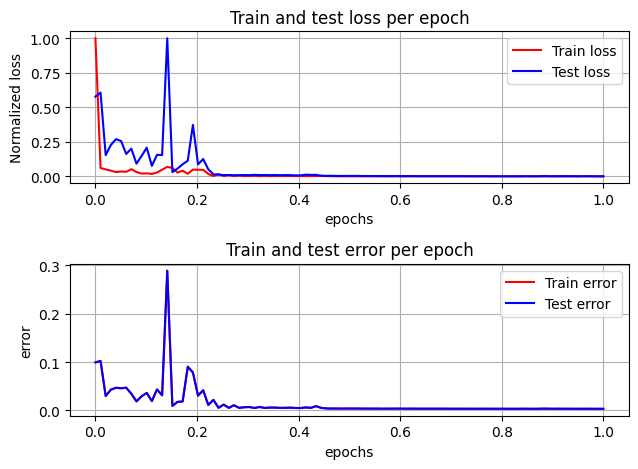

In [28]:
# Instantiate the model
model_6 = LeakyReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_6, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

leakyrelu = eval_model(model_6, test_loader, loss_fn, device,True)
save_model_info(model_6,os.path.join(new_folder_path,leakyrelu["model_name"]))

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [29]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.4694610548913479 | Loss test: 0.17695501671423988 | lr = 0.01
Epoch 10 | Loss train: 0.12398872463405132 | Loss test: 0.15563033946922847 | lr = 0.01
Epoch 20 | Loss train: 0.12816449542343616 | Loss test: 0.14601788693477238 | lr = 0.01
Epoch 30 | Loss train: 0.13184736496210098 | Loss test: 0.10419116192866885 | lr = 0.01
Epoch 40 | Loss train: 0.1351759302020073 | Loss test: 0.08323796566516634 | lr = 0.01
Epoch 50 | Loss train: 0.13435309171676635 | Loss test: 0.10813725077443653 | lr = 0.01
Epoch 60 | Loss train: 0.04798115076869726 | Loss test: 0.04699754531657885 | lr = 0.001
Epoch 70 | Loss train: 0.042128396175801754 | Loss test: 0.04579567548538011 | lr = 0.001
Epoch 80 | Loss train: 0.038619675479829314 | Loss test: 0.04046060103509161 | lr = 0.001
Epoch 90 | Loss train: 0.03945233575999737 | Loss test: 0.039192385823717195 | lr = 0.001
Epoch 100 | Loss train: 0.03740868160128594 | Loss test: 0.04125364686525057 | lr = 0.001


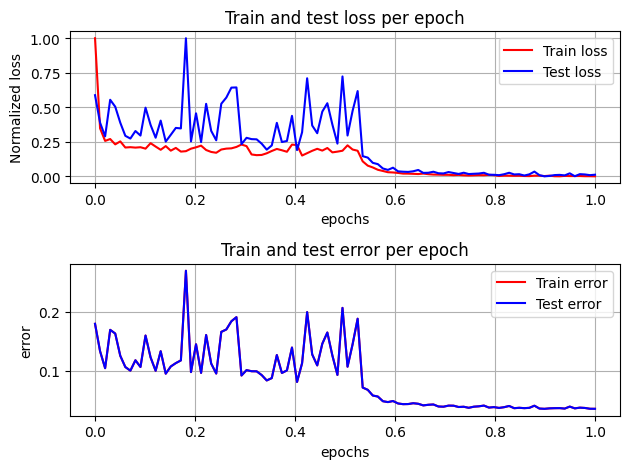

In [30]:
# Instantiate the model
model_8 = tanhModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_8.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_8, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

tanh_model = eval_model(model_8, test_loader, loss_fn, device,True)
save_model_info(model_8,os.path.join(new_folder_path,tanh_model["model_name"]))

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [31]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.206799655854702 | Loss test: 0.09901090486655159 | lr = 0.01
Epoch 10 | Loss train: 0.04036371204257012 | Loss test: 0.03333176944463972 | lr = 0.01
Epoch 20 | Loss train: 0.03395323165878653 | Loss test: 0.03384992063400291 | lr = 0.01
Epoch 30 | Loss train: 0.02828785103932023 | Loss test: 0.023116137699357102 | lr = 0.01
Epoch 40 | Loss train: 0.025308829475194215 | Loss test: 0.01745109302952649 | lr = 0.01
Epoch 50 | Loss train: 0.010343426221981644 | Loss test: 0.010797585685929608 | lr = 0.001
Epoch 60 | Loss train: 0.009051448669284583 | Loss test: 0.009449476716182535 | lr = 0.001
Epoch 70 | Loss train: 0.008314421171322466 | Loss test: 0.008894257801806643 | lr = 0.001
Epoch 80 | Loss train: 0.007973940223455428 | Loss test: 0.008964335043278952 | lr = 0.001
Epoch 90 | Loss train: 0.007548097021877765 | Loss test: 0.008719899898601903 | lr = 0.001
Epoch 100 | Loss train: 0.007175284894183278 | Loss test: 0.008141497150063515 | lr = 0.001


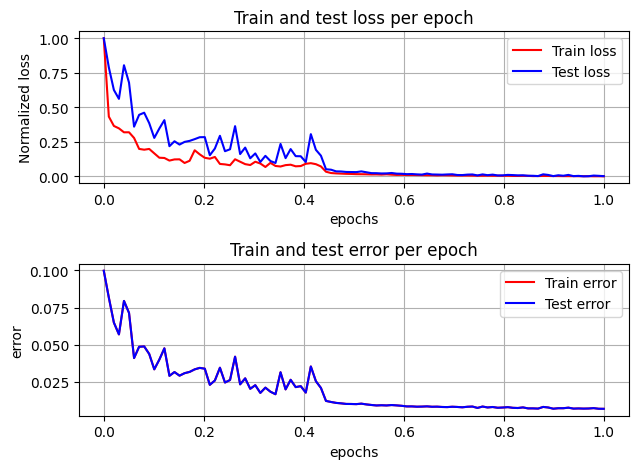

In [32]:
# Instantiate the model
model_9 = sigmoidModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_9.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_9, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

sigmoid_model = eval_model(model_9, test_loader, loss_fn, device, True)
save_model_info(model_9,os.path.join(new_folder_path,sigmoid_model["model_name"]))

### Αρχιτεκτονική 3

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [33]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.9869200924113393 | Loss test: 0.09307776178632464 | lr = 0.01
Epoch 10 | Loss train: 0.08910267698206008 | Loss test: 0.010555168791186242 | lr = 0.01
Epoch 20 | Loss train: 0.05009545102808625 | Loss test: 0.019686131812040767 | lr = 0.01
Epoch 30 | Loss train: 0.006084121264517307 | Loss test: 0.005286854669629108 | lr = 0.001
Epoch 40 | Loss train: 0.0045800873772241174 | Loss test: 0.004200969981620946 | lr = 0.001
Epoch 50 | Loss train: 0.004687611676286906 | Loss test: 0.00457772392306536 | lr = 0.001
Epoch 60 | Loss train: 0.003586396192666143 | Loss test: 0.0035704909232518976 | lr = 0.0001
Epoch 70 | Loss train: 0.0034795918380841613 | Loss test: 0.003527972775156654 | lr = 0.0001
Epoch 80 | Loss train: 0.003413299012929201 | Loss test: 0.0035675570852906693 | lr = 0.0001
Epoch 90 | Loss train: 0.003370109866373241 | Loss test: 0.003580689587305108 | lr = 0.0001
Epoch 100 | Loss train: 0.0033293382888659835 | Loss test: 0.003442691457975242 | lr = 0.000

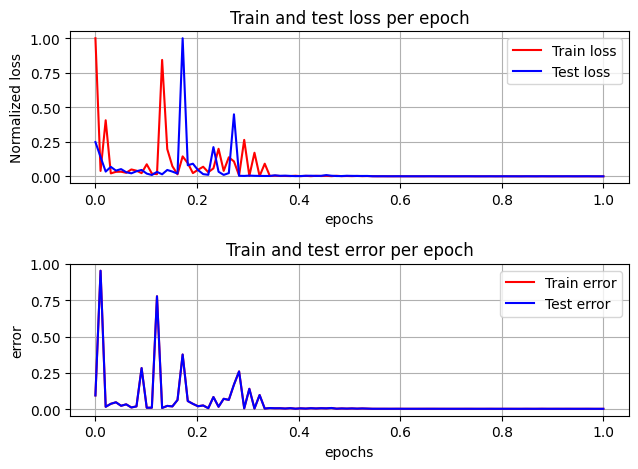

In [34]:
# Instantiate the model
model_10 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_10, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

leakyrelu_4 = eval_model(model_10, test_loader, loss_fn, device,True)
save_model_info(model_10,os.path.join(new_folder_path,leakyrelu_4["model_name"]))

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

### Αρχιτεκτονική 4

#### Dropout

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [35]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.067916772276163 | Loss test: 0.2830096573110611 | lr = 0.01
Epoch 10 | Loss train: 0.13568773441016674 | Loss test: 0.0718483722044362 | lr = 0.01
Epoch 20 | Loss train: 0.15824689263105393 | Loss test: 0.07480444930612094 | lr = 0.001
Epoch 30 | Loss train: 0.019810868669301273 | Loss test: 0.015239207295789606 | lr = 0.001
Epoch 40 | Loss train: 0.016279305346310138 | Loss test: 0.017198173403148612 | lr = 0.001
Epoch 50 | Loss train: 0.014905954897403716 | Loss test: 0.018179588625946687 | lr = 0.001
Epoch 60 | Loss train: 0.015067977955564856 | Loss test: 0.020622229247930505 | lr = 0.001
Epoch 70 | Loss train: 0.015680655999109148 | Loss test: 0.02154612418500677 | lr = 0.001
Epoch 80 | Loss train: 0.01412233879044652 | Loss test: 0.02294040085481746 | lr = 0.001
Epoch 90 | Loss train: 0.014465027594938874 | Loss test: 0.02084331830874795 | lr = 0.0001
Epoch 100 | Loss train: 0.009358810044825076 | Loss test: 0.020616223769528524 | lr = 0.0001


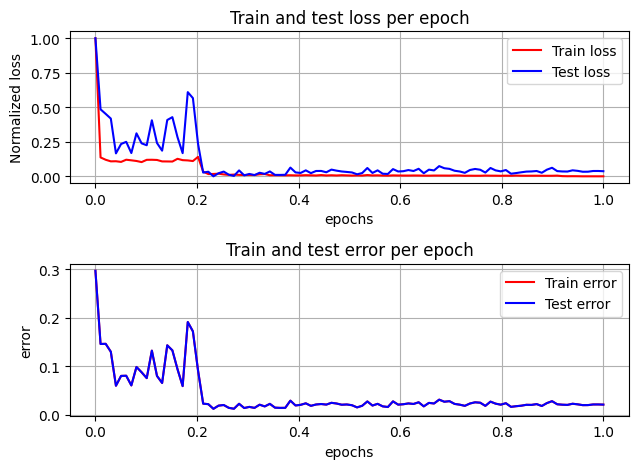

In [36]:
# Instantiate the model
model_11 = LeakyReLUModelDropout(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_11.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Load the data
train_loss, test_loss, train_err, test_err = train_test_model(epoch = 100,model = model_11, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler, device=device)

plot_results(train_loss, test_loss,train_err,test_err)

dropout_model = eval_model(model_11, test_loader, loss_fn, device,True)
save_model_info(model_11,os.path.join(new_folder_path,dropout_model["model_name"]))

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [37]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

xgb_loss = mean_squared_error(y_test, y_pred)

xgb_res = {'model_name': 'xgb_model', 'model_loss' : xgb_loss}

c:\Users\giama\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
c:\Users\giama\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:31:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
c:\Users\giama\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\context.cc:43: No visible GPU is found, setting device to CPU.
  warni

### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [39]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [40]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'model_loss' : test_loss.cpu().item()}
save_model_info(model_13,os.path.join(new_folder_path,epoch_res["model_name"]))

Epoch: 0 | Train Loss: 2.09935 | Test Loss: 6.46282
Epoch: 100 | Train Loss: 0.40159 | Test Loss: 0.39571
Epoch: 200 | Train Loss: 0.40051 | Test Loss: 0.39483
Epoch: 300 | Train Loss: 0.40048 | Test Loss: 0.39480
Epoch: 400 | Train Loss: 0.40044 | Test Loss: 0.39476
Epoch: 500 | Train Loss: 0.40040 | Test Loss: 0.39471
Epoch: 600 | Train Loss: 0.40035 | Test Loss: 0.39466
Epoch: 700 | Train Loss: 0.40030 | Test Loss: 0.39461
Epoch: 800 | Train Loss: 0.40025 | Test Loss: 0.39455
Epoch: 900 | Train Loss: 0.40019 | Test Loss: 0.39449
Epoch: 1000 | Train Loss: 0.40013 | Test Loss: 0.39443


## Results

In [42]:
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, relu_model,dropout_model, sigmoid_model, tanh_model])
compare_results = compare_results._append(xgb_res, ignore_index = True)
compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'model_loss', ascending= True, inplace= True)
compare_results

,model_name,model_loss
1,LeakyReLUModel4,0.003443
0,LeakyReLUModel,0.003491
2,ReLUModel,0.004468
6,xgb_model,0.006250
4,sigmoidModel,0.008141
3,LeakyReLUModelDropout,0.020616
5,tanhModel,0.041254
7,LeakyReLU4_noBatches,0.394434


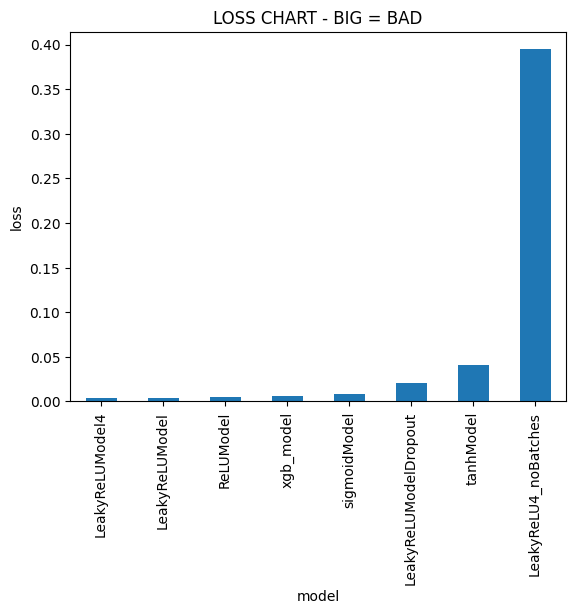

In [43]:
# Visualize our model results
compare_results.set_index("model_name")["model_loss"].plot(kind="bar")
plt.xlabel("model")
plt.ylabel("loss")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***